In [22]:
import numpy as np
import scipy
import sklearn.svm
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

In [23]:
M = scipy.stats.multivariate_normal(mean=np.zeros(2), cov=3)
D = scipy.stats.multivariate_normal(mean=np.zeros(2), cov=1)

def sample_dataset(means, N=100):
    K = means.shape[0]
    mean_choice = np.random.choice(K, size=N)
    distortion = D.rvs(N)
    return means[mean_choice] + distortion

def pdf_means(means, x):
    K = means.shape[0]
    p = np.zeros(x.shape[0])
    for m in means:
        p += 1/K * scipy.stats.multivariate_normal.pdf(x, mean=m, cov=1)
    return p
    
def sample_means(K=5):
    return M.rvs(K)

def bundle_data(data_class1, data_class2):
    data_all = np.concatenate([data_class1, data_class2])
    labels_all = np.concatenate([
        np.zeros(data_class1.shape[0]), np.ones(data_class2.shape[0])
    ])
    return data_all, labels_all

def sample_datasets(means_class0, means_class1, M=100, N=100):
    datasets = []
    for i in range(M):
        data_class1 = sample_dataset(means_class0, N)
        data_class2 = sample_dataset(means_class1, N)
        datasets.append(bundle_data(data_class1, data_class2))
    return datasets

In [514]:
np.random.seed(189)
means_class0 = sample_means() + np.array([0, 1])
means_class1 = sample_means() + np.array([1, 0])

In [515]:
def plot_data(plt, dataset, means=False, alpha=0.2):
    data, labels = dataset
    data_class0 = data[labels == 0.0]
    data_class1 = data[labels == 1.0]
    if means:
        plt.scatter(*means_class0.T, label='class 0 means', color='blue', marker='o', linewidths=5)
        plt.scatter(*means_class1.T, label='class 1 means', color='gold', marker='o', linewidths=5)
    plt.scatter(*data_class0.T, label='class 0 datapoints', alpha=alpha, color='blue')
    plt.scatter(*data_class1.T, label='class 1 datapoints', alpha=alpha, color='gold')

In [516]:
plot_dataset = sample_datasets(means_class0, means_class1, M=1, N=500)[0]

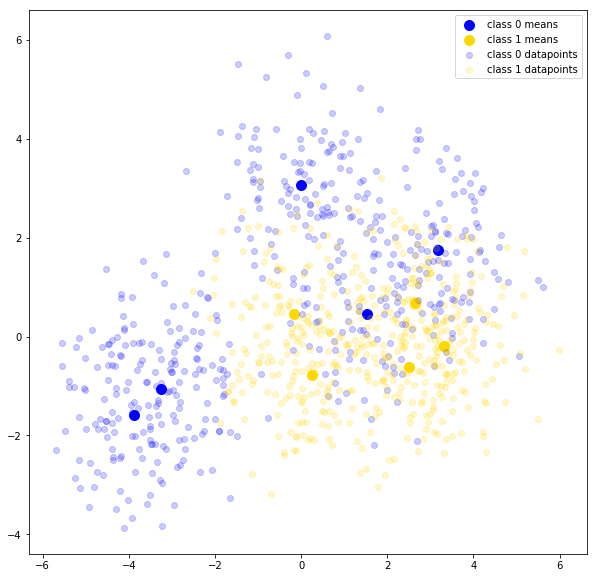

In [517]:
plt.figure(figsize=(10 , 10))
plot_data(plt,plot_dataset, means=True)
plt.legend()
plt.show()

In [791]:
def s(x):
    return scipy.special.expit(x)

def loss_wXy(w, X, y, avg=False, lam=None):
    L = loss_ys(y, s(X @ w), avg)
    if lam is not None:
        L += lam * (w @ w)
    return L

def loss_ys(y, s, avg=False):
    L = - (y * np.log(s) + (1-y)*np.log(1-s)).sum(axis=0)
    if avg: return L / y.shape[0]
    else: return L

# X is design
def grad_log(w, X, y, lam=None):
    G = X.T @ (s(X @ w) - y)
    return G

def update(w, g, eps):
    return w - eps * g

def batch_descent(w, X, y, eps, lam=None):
    G = grad_log(w, X, y) / X.shape[0]
    if lam is not None:
        G += 2 * lam * w
    return update(w, G, eps)

def stochastic_descent(w, X, y, eps, lam=None):
    i = np.random.randint(0, X.shape[0])
    X_t = X[i:i+1]
    y_t = y[i:i+1]
    return batch_descent(w, X_t, y_t, eps, lam=lam)

#M = num iterations
def log_reg(dataset, descent, eps, M=10000, lam=None):
    data, labels = dataset
    data = np.concatenate([data, np.ones((data.shape[0], 1))], axis=1)
    N, D = data.shape
    ws = np.empty((M, D))
    losses = np.empty((M))
    ws[0] = np.zeros(D)
    losses[0] = loss_wXy(ws[0], data, labels, avg=True)
    i = 1
    while i < M:
        ws[i] = descent(ws[i - 1], data, labels, eps, lam=lam)
        losses[i] = loss_wXy(ws[i], data, labels, avg=True, lam=lam)
        i += 1
    return ws, losses

In [825]:
train_dataset = sample_datasets(means_class0, means_class1, M=1, N=50)[0]
ws, losses = log_reg(train_dataset, batch_descent, 1e-3)
ws_stoc, losses_stoc = log_reg(train_dataset, stochastic_descent, 1e-3)

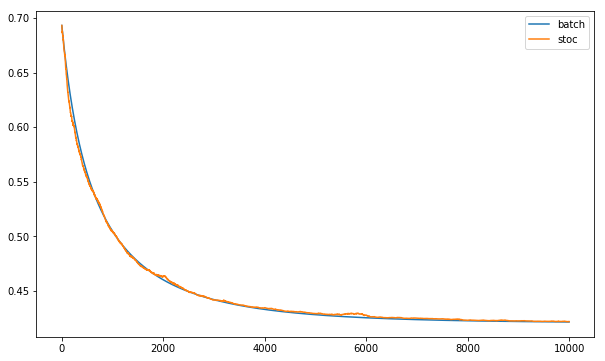

In [826]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='batch')
plt.plot(losses_stoc, label='stoc')
plt.legend()
plt.show()

In [804]:
X_m, Y_m = np.meshgrid(np.linspace(-6, 8), np.linspace(-4, 8))

In [805]:
def biasify(X):
    return np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

In [806]:
def hyp(w, data):
    data = np.concatenate([data, np.ones((data.shape[0], 1))], axis=1)
    return (data @ w).reshape((50, 50))

In [807]:
X_design = np.stack([X_m, Y_m], axis=2).reshape((-1, 2))

In [808]:
hyp_z = hyp(ws[10], X_design).reshape((50, 50))

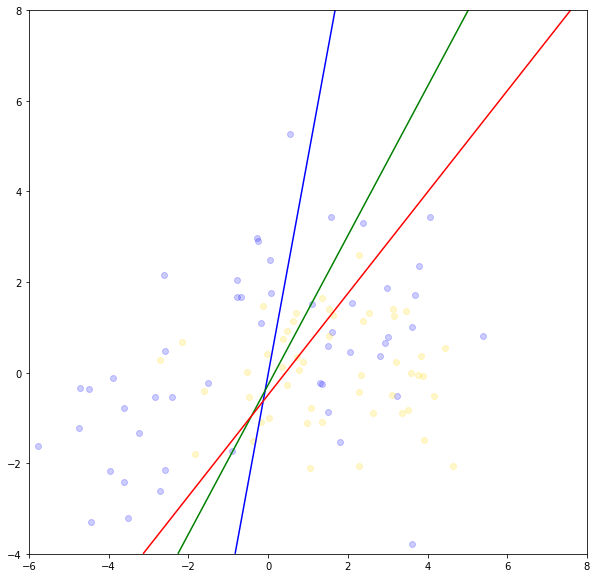

In [809]:
plt.figure(figsize=(10, 10))
plot_data(plt, train_dataset)
plt.contour(X_m, Y_m, hyp(ws[100], X_design), [0], colors='blue')
plt.contour(X_m, Y_m, hyp(ws[2000], X_design), [0], colors='green')
plt.contour(X_m, Y_m, hyp(ws[-1], X_design), [0], colors='red')
# plt.contour(X_m, Y_m, hyp_z, [0])
plt.show()

In [810]:
ws_reg, losses_reg = log_reg(train_dataset, batch_descent, 1e-3, lam=0.05)

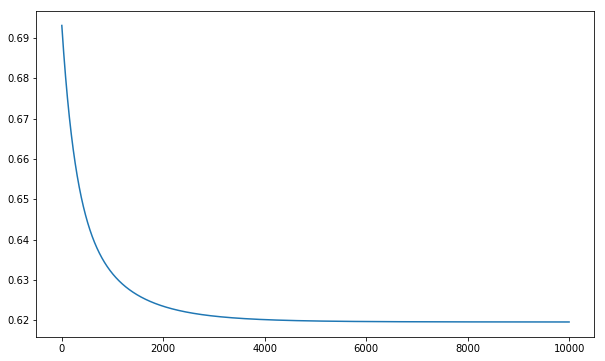

In [811]:
plt.figure(figsize=(10, 6))
plt.plot(losses_reg)
plt.show()

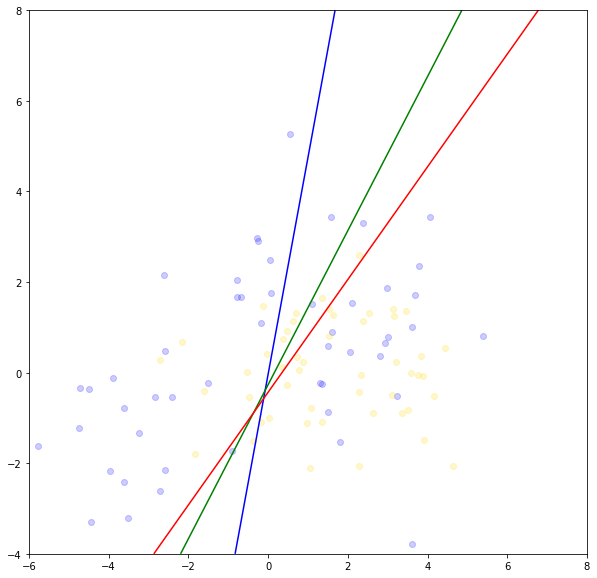

In [812]:
plt.figure(figsize=(10, 10))
plot_data(plt, train_dataset)
plt.contour(X_m, Y_m, hyp(ws_reg[100], X_design), [0], colors='blue')
plt.contour(X_m, Y_m, hyp(ws_reg[2000], X_design), [0], colors='green')
plt.contour(X_m, Y_m, hyp(ws_reg[-1], X_design), [0], colors='red')
# plt.contour(X_m, Y_m, hyp_z, [0])
plt.show()

In [813]:
test_dataset = sample_datasets(means_class0, means_class1, M=1, N=100)[0]

In [814]:
def test_losses(ws, dataset):
    data, labels = dataset
    data_biased = biasify(test_dataset[0])
    N = ws.shape[0]
    losses = np.empty(N)
    for i in range(N):
        losses[i] = loss_wXy(ws[i], data_biased, labels, avg=True)
    return losses

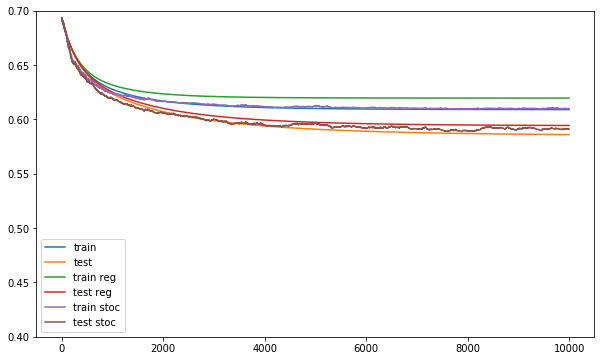

In [815]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='train')
plt.plot(test_losses(ws, test_dataset), label='test')
plt.plot(losses_reg, label='train reg')
plt.plot(test_losses(ws_reg, test_dataset), label='test reg')
plt.plot(losses_stoc, label='train stoc')
plt.plot(test_losses(ws_stoc, test_dataset), label='test stoc')
plt.ylim(0.4, 0.7)
plt.legend()
plt.show()

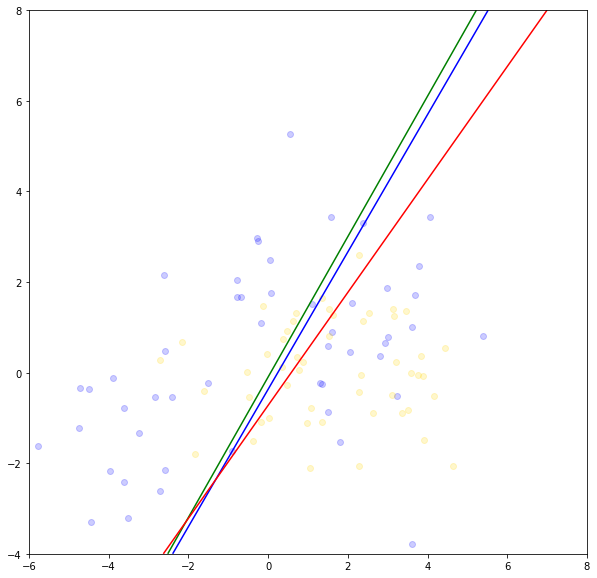

In [816]:
plt.figure(figsize=(10, 10))
plot_data(plt, train_dataset)
plt.contour(X_m, Y_m, hyp(ws_stoc[100], X_design), [0], colors='blue')
plt.contour(X_m, Y_m, hyp(ws_stoc[2000], X_design), [0], colors='green')
plt.contour(X_m, Y_m, hyp(ws_stoc[-1], X_design), [0], colors='red')
# plt.contour(X_m, Y_m, hyp_z, [0])
plt.show()